In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR

import math
import warnings

/Users/tailtq/opt/anaconda3/envs/python-cvcourse/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
warnings.filterwarnings('ignore')

### --- Steps ---:
1. Check missing values
2. Data exploitation (map)
3. Check outliers
4. Feature scaling
5. Use multiple models (model selection)

### Load dataset

In [3]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df.describe(include='all')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
unique,10886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2011-07-13 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,NaN,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,NaN,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,NaN,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000


### Check missing values

In [4]:
for key in ['temp', 'atemp', 'humidity', 'windspeed']:
    print('(Train) Missing values of {} are {} elements'.format(key, len(df[key].loc[lambda x: x == 0])))

print('\n')

for key in ['temp', 'atemp', 'humidity', 'windspeed']:
    print('(Test) Missing values of {} are {} elements'.format(key, len(df_test[key].loc[lambda x: x == 0])))

(Train) Missing values of temp are 0 elements
(Train) Missing values of atemp are 0 elements
(Train) Missing values of humidity are 22 elements
(Train) Missing values of windspeed are 1313 elements


(Test) Missing values of temp are 0 elements
(Test) Missing values of atemp are 2 elements
(Test) Missing values of humidity are 0 elements
(Test) Missing values of windspeed are 867 elements


In [5]:
time_range1 = 6
time_range2 = 19

In [6]:
# set mean of humidity of the same month and same time
df['year'] = df['datetime'].str[0:4]
df['month'] = df['datetime'].str[5:7]
# df['day'] = df['datetime'].str[8:10]
df['time'] = df['datetime'].str[11:13]

df['humidity'].replace(0, np.nan, inplace=True)
df['humidity'] = df.groupby(['year', 'month', 'time'])['humidity'].transform(lambda x: x.fillna(x.mean()))

df['is_day'] = df['time'].astype(int).between(time_range1, time_range2).astype(int)
df['commuting_to_work'] = df['time'].astype(int).apply(lambda x: (x >= 6 and x <= 8) or
                                                                 (x >= 16 and x <= 19)).astype(int)

df = df.drop(['year', 'datetime'], axis=1)

In [7]:
df['season'].value_counts(normalize=True)

4    0.251148
3    0.251056
2    0.251056
1    0.246739
Name: season, dtype: float64

In [8]:
df.isna().sum()

season               0
holiday              0
workingday           0
weather              0
temp                 0
atemp                0
humidity             0
windspeed            0
casual               0
registered           0
count                0
month                0
time                 0
is_day               0
commuting_to_work    0
dtype: int64

### Data visualization

#### 1. Dataset

##### Histogram

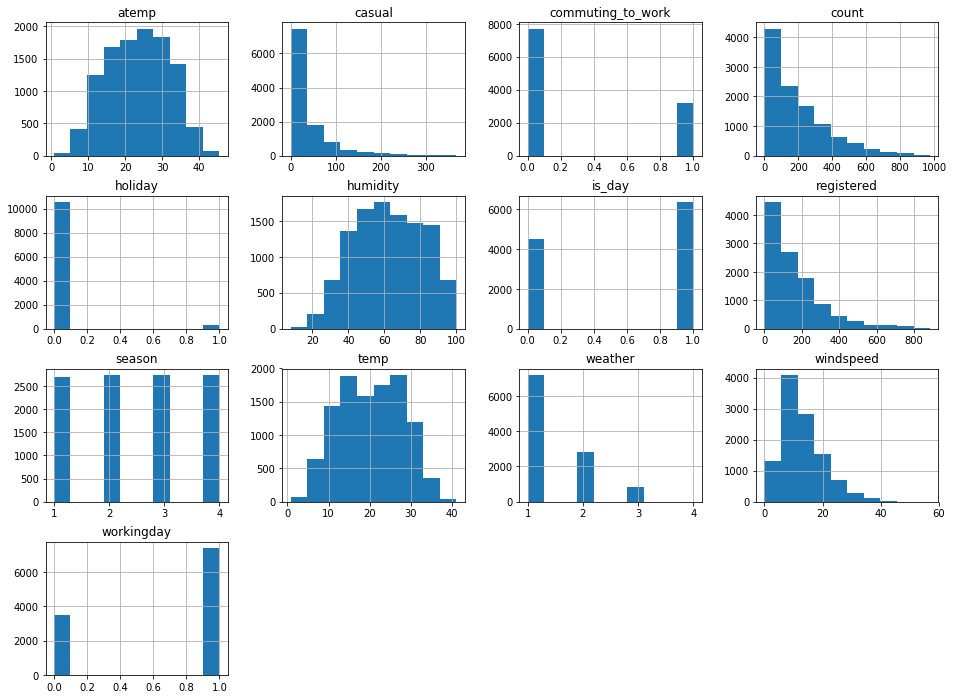

In [9]:
plt.rcParams['figure.figsize'] = (16, 12)
df.hist();

##### Correlation

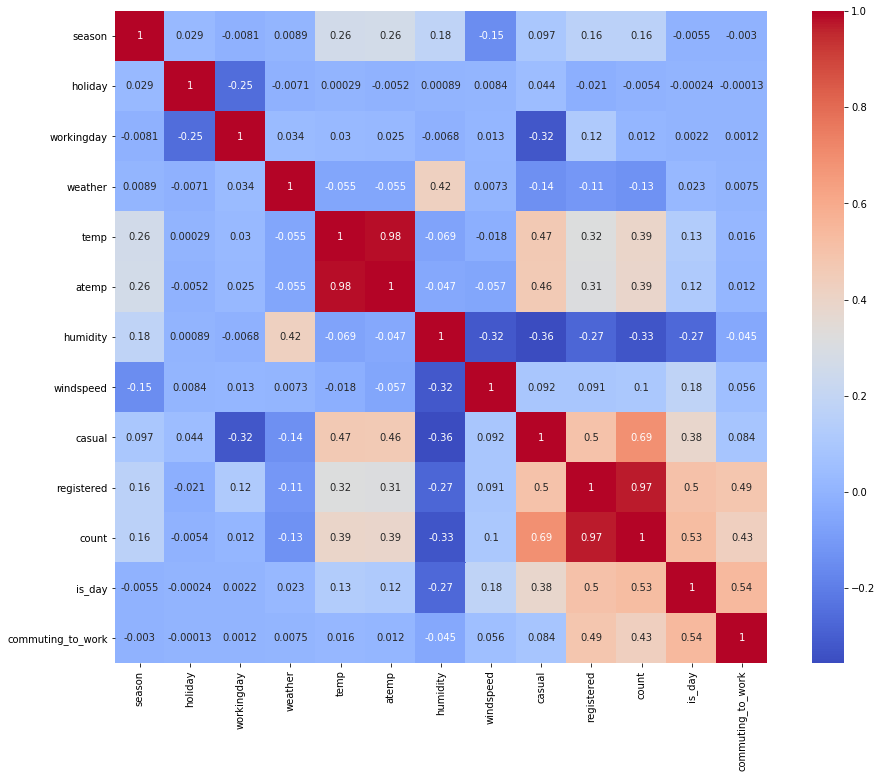

In [10]:
sns.heatmap(df.corr(), annot=True, square=True, cmap='coolwarm');

#### Interaction between features

##### Category - Numeric

In [11]:
# try with atemp to compare two probability
data = df.drop(['temp'], axis=1)
# data = df.drop('atemp', axis=1)
# temp works better

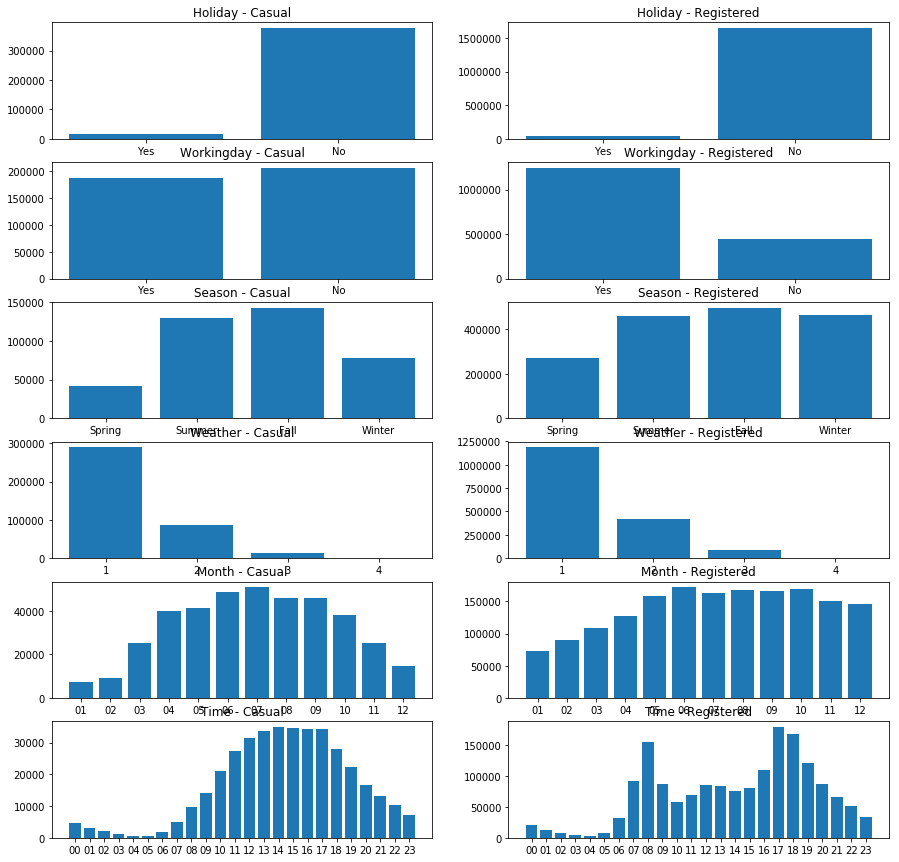

In [12]:
def get_sum(key, key2, value):
    return data[data[key] == value][key2].sum()

def get_sum_casual(key, value):
    return data[data[key] == value]['casual'].sum()

def get_sum_registered(key, value):
    return data[data[key] == value]['registered'].sum()

fig, ax = plt.subplots(6, 2, figsize=(15, 15))

yes_no = ['Yes', 'No']
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
weathers = data['weather'].unique().astype(str)
months = data['month'].unique()
# days = data['day'].unique()
times = data['time'].unique()

ax[0][0].bar(yes_no,
             [get_sum_casual('holiday', 1),
              get_sum_casual('holiday', 0)])
ax[0][1].bar(yes_no,
             [get_sum_registered('holiday', 1),
              get_sum_registered('holiday', 0)])
ax[0][0].set_title('Holiday - Casual')
ax[0][1].set_title('Holiday - Registered')


ax[1][0].bar(yes_no,
             [get_sum_casual('workingday', 1),
              get_sum_casual('workingday', 0)])
ax[1][1].bar(yes_no,
             [get_sum_registered('workingday', 1),
              get_sum_registered('workingday', 0)])
ax[1][0].set_title('Workingday - Casual')
ax[1][1].set_title('Workingday - Registered')


ax[2][0].bar(seasons,
             [get_sum_casual('season', 1),
              get_sum_casual('season', 2),
              get_sum_casual('season', 3),
              get_sum_casual('season', 4)])
ax[2][1].bar(seasons,
             [get_sum_registered('season', 1),
              get_sum_registered('season', 2),
              get_sum_registered('season', 3),
              get_sum_registered('season', 4)])
ax[2][0].set_title('Season - Casual')
ax[2][1].set_title('Season - Registered')

ax[3][0].bar(weathers,
             [get_sum_casual('weather', 1),
              get_sum_casual('weather', 2),
              get_sum_casual('weather', 3),
              get_sum_casual('weather', 4)])
ax[3][1].bar(weathers,
             [get_sum_registered('weather', 1),
              get_sum_registered('weather', 2),
              get_sum_registered('weather', 3),
              get_sum_registered('weather', 4)])
ax[3][0].set_title('Weather - Casual')
ax[3][1].set_title('Weather - Registered')

month_data1 = []
month_data2 = []

# day_data1 = []
# day_data2 = []

time_data1 = []
time_data2 = []

for i in months:
    month_data1.append(get_sum_casual('month', i))
    month_data2.append(get_sum_registered('month', i))

# for i in days:
#     day_data1.append(get_sum_casual('day', i))
#     day_data2.append(get_sum_registered('day', i))

for i in times:
    time_data1.append(get_sum_casual('time', i))
    time_data2.append(get_sum_registered('time', i))
    
ax[4][0].bar(months, month_data1)
ax[4][1].bar(months, month_data2)
ax[4][0].set_title('Month - Casual')
ax[4][1].set_title('Month - Registered')

# ax[5][0].bar(days, day_data1)
# ax[5][1].bar(days, day_data2)

ax[5][0].bar(times, time_data1)
ax[5][1].bar(times, time_data2)
ax[5][0].set_title('Time - Casual')
ax[5][1].set_title('Time - Registered')

# # balanced feature --> remove
# data = data.drop(['day'], axis=1)

plt.show()

In [13]:
print(df['casual'].sum(), df['registered'].sum())

392135 1693341


### Feature scaling

In [14]:
data['season'] = data['season'].astype(str)
data_with_dummies = pd.get_dummies(data, drop_first=True)

In [15]:
scaled_features = ['temp', 'atemp', 'humidity', 'windspeed']

for feature in scaled_features:
    if feature in data_with_dummies.columns.values:
        data_with_dummies[feature] /= data_with_dummies[feature].max()

In [16]:
data_with_dummies.describe()

,holiday,workingday,weather,atemp,humidity,windspeed,casual,registered,count,is_day,...,time_14,time_15,time_16,time_17,time_18,time_19,time_20,time_21,time_22,time_23
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,1.418427,0.520407,0.620037,0.224563,36.021955,155.552177,191.574132,0.58589,...,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889,0.041889
std,0.166599,0.466159,0.633839,0.186439,0.190479,0.143245,49.960477,151.039033,181.144454,0.49259,...,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344,0.200344
min,0.000000,0.000000,1.000000,0.016720,0.080000,0.000000,0.000000,0.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.366626,0.470000,0.122840,4.000000,36.000000,42.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.533275,0.620000,0.228047,17.000000,118.000000,145.000000,1.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,2.000000,0.683313,0.770000,0.298225,49.000000,222.000000,284.000000,1.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,367.000000,886.000000,977.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
X = data_with_dummies.drop(['casual', 'count', 'registered'], axis=1)
y = data_with_dummies[['casual', 'registered']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Model selection

In [19]:
model11 = RandomForestRegressor(n_estimators=400, random_state=0)
model11.fit(X_train.drop('commuting_to_work', axis=1), y_train['casual'])
model11.score(X_test.drop('commuting_to_work', axis=1), y_test['casual'])

0.8540203273295877

In [20]:
model12 = RandomForestRegressor(n_estimators=400, random_state=0)
model12.fit(X_train, y_train['registered'])
model12.score(X_test, y_test['registered'])

0.8524385321403253

### Get result

In [21]:
# set mean of humidity of the same month and same time
df_test['year'] = df_test['datetime'].str[0:4]
df_test['month'] = df_test['datetime'].str[5:7]
df_test['time'] = df_test['datetime'].str[11:13]

df_test['humidity'].replace(0, np.nan, inplace=True)
df_test['humidity'] = df_test.groupby(['year', 'month', 'time'])['humidity'].transform(lambda x: x.fillna(x.mean()))

df_test['atemp'].replace(0, np.nan, inplace=True)
df_test['atemp'] = df_test.groupby(['year', 'month', 'time'])['atemp'].transform(lambda x: x.fillna(x.mean()))

df_test['is_day'] = df_test['time'].astype(int).between(time_range1, time_range2).astype(int)
df_test['commuting_to_work'] = df_test['time'].astype(int).apply(lambda x: (x >= 6 and x <= 8) or
                                                                 (x >= 16 and x <= 19)).astype(int)

df_datetime = df_test[['datetime']]
data2 = df_test.drop(['year', 'datetime', 'temp'], axis=1)

In [22]:
data2['season'] = data2['season'].astype(str)
data_with_dummies2 = pd.get_dummies(data2, drop_first=True)

for feature in scaled_features:
    if feature in data_with_dummies2.columns.values:
        data_with_dummies2[feature] /= data_with_dummies2[feature].max()

In [23]:
df_datetime['count'] = np.round(model11.predict(data_with_dummies2.drop('commuting_to_work', axis=1)) + model12.predict(data_with_dummies2)).astype(int)

In [24]:
df_datetime.to_csv(path_or_buf='result.csv', index=False)

In [26]:
importances = pd.DataFrame({ 'columns': X_train.drop('commuting_to_work', axis=1).columns.values, 'percent': model11.feature_importances_ * 100 }) 
importances.sort_values('percent', ascending=False)

,columns,percent
3,atemp,29.206550
1,workingday,17.257075
6,is_day,15.723102
4,humidity,13.100891
5,windspeed,3.389570
27,time_07,1.842569
26,time_06,1.764804
28,time_08,1.459209
40,time_20,1.269481
29,time_09,1.119785


In [27]:
importances = pd.DataFrame({ 'columns': X_train.columns.values, 'percent': model12.feature_importances_ * 100 }) 
importances.sort_values('percent', ascending=False)

,columns,percent
6,is_day,24.467075
1,workingday,11.892720
3,atemp,11.643815
4,humidity,6.820056
7,commuting_to_work,6.705823
27,time_06,6.645647
5,windspeed,3.627118
41,time_20,3.477152
10,season_4,2.358881
29,time_08,2.352912
